In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [6]:
powers['unlensed_scalar'].shape

(29901, 4)

In [7]:
cl.shape

(30001, 3)

In [8]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [9]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [10]:
ps_data = {}
data = {}

In [11]:
pairs = [
    [-1, -1], #lensed
    [-2, -2], #GRF
    [-3, -3]  #randomized phase
]
data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

# pbar = trange(len(pairs))
for file_idx in trange(1,18): 
    for pair_idx in range(len(pairs)):
        pair = pairs[pair_idx]
        c_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/estimators_FILE%d_pair_%d_%d.pkl'%(file_idx, pair[0], pair[1])
        if(not os.path.isfile(c_fname)):
            continue
        f = open(c_fname, 'rb')  
        c_data = pickle.load(f)
        f.close()
        
        pair_things = '%d%d'%(pair[0],pair[1])
        ck = pair_things
        for data_idx in range(len(c_data['%s_sqrtN'%(pair_things)])):
            sqrtNhat = c_data['%s_sqrtN'%(pair_things)][data_idx]

            c_ps_data = {}
            c_ps_data[ck] = [0,0,0]
            c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
            if(ck not in ps_data.keys()):
                ps_data[ck] = np.array([c_ps_data[ck]])
            else:
                ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        

100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


In [12]:
print(data.keys())

dict_keys([])


In [13]:
# #estimate Nhat
# ck = 'Nhat'
# for data_idx in trange(len(data['-1-1_sqrtN'])):
#     sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        
# print(ps_data[ck].shape)

In [14]:
# #estimate GRF Nhat
# ck = 'GRF'
# for data_idx in trange(len(data['-2-2_sqrtN'])):
#     sqrtNhat = data['-2-2_sqrtN'][data_idx]
    
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

In [15]:
# #estimate GRF Nhat
# ck = 'GRF random'
# for data_idx in trange(len(data['-3-3_sqrtN'])):
#     sqrtNhat = data['-3-3_sqrtN'][data_idx]
    
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

In [16]:
# ck = 'QEQE'
# for data_idx in trange(len(data['-1-1'])):
#     sqrtNhat = data['-1-1'][data_idx]
    
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        
# print(ps_data[ck].shape)

In [17]:
ps_data.keys()

dict_keys(['-1-1', '-2-2', '-3-3'])

In [18]:


LBinned, NtheoryBinned = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)


In [19]:
LBinned, fKKBinned = baseMap.binTheoryPowerSpectrum(fKK, nBins=nBins)


In [20]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    
    Cls = np.mean(Cls_tot[:,1,:], axis=0)
    sCls = np.std(Cls_tot[:,1,:], axis=0)/np.sqrt(n_runs)
#     sCls = np.sqrt(np.sum(np.square(Cls_tot[:,2,:]), axis=0))/n_runs 

    return lCen, Cls, sCls

170 (170, 3, 50)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.79320376e-08
 0.00000000e+00 7.81749289e-08 0.00000000e+00 7.84153039e-08
 7.86521808e-08 7.93442957e-08 7.99180760e-08 8.06735420e-08
 8.19189828e-08 8.36365087e-08 8.61199221e-08 8.89465251e-08
 9.25893929e-08 9.66161085e-08 9.98504762e-08 1.01600482e-07
 1.01520628e-07 1.01342083e-07 1.02244206e-07 1.02272622e-07
 1.02024638e-07 1.02145583e-07 1.02111273e-07 1.02828226e-07
 1.06281590e-07 1.17629511e-07 1.54483534e-07 2.56013627e-07
 3.18126282e-07 9.32120241e-07 8.04054855e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
170 (170, 3, 50)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.0

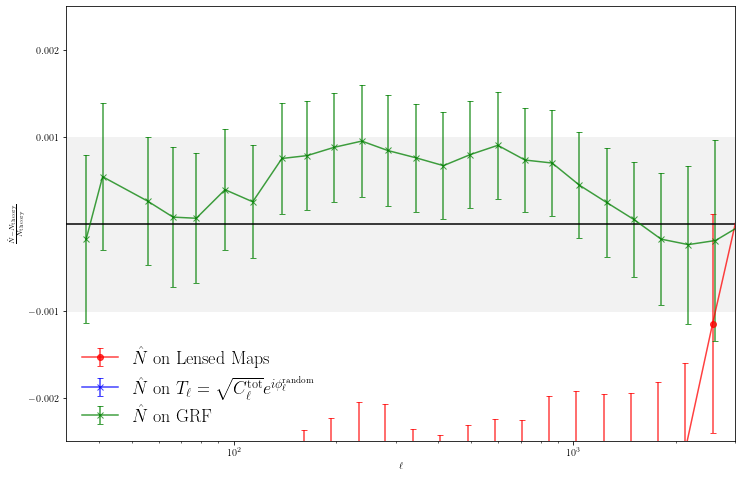

In [21]:
offset=0.01


fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['-1-1']))
lCen1, Cl1, sCl1 = LBinned, NtheoryBinned, np.zeros_like(sCl0)




# print((Cl0-Cl1)/Cl0)
assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='o-', capsize=3, capthick=1, c='red', label=r'$\hat N$ on Lensed Maps')#, label=labels[key], c=colors[key])
print(Cl0)
tmp = [l*np.exp(offset*1)-l for l in lCen0]


lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['-3-3']))
ax.errorbar(lCen0+tmp, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='blue', label=r'$\hat N$ on $T_\ell = \sqrt{C_\ell^{\rm tot}} e^{i\phi_\ell^{\rm random}}$')#, label=labels[key], c=colors[key])
print(Cl0)

tmp = [l*np.exp(offset*2)-l for l in lCen0]

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['-2-2']))
ax.errorbar(lCen0+tmp, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='Green', label=r'$\hat N$ on GRF')#, label=labels[key], c=colors[key])

# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF havled']))
# ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='lightgreen', label=r'$\hat N$ on GRF [Halved Stats]')#, label=labels[key], c=colors[key])


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.95')#, label=r'$<1\%$ Error')

# ax.set_yscale('symlog', linthresh=.5e-2) 

ax.axhline(0, c='k')

ax.set_ylim(-.25e-2, .25e-2)
ax.set_xlim(32, 3000)
ax.set_yticks([-0.001,- 0.002,0.001, 0.002])
ax.legend(frameon=False)
# ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])
plt.savefig('figures/Nhat various.pdf', bbox_inches='tight')

In [22]:
ra = (baseMap.sizeX + baseMap.dX)*(baseMap.sizeY + baseMap.dY)/ (baseMap.sizeX * baseMap.sizeY)
ra = ra**(3/2)

170 (170, 3, 50)
170 (170, 3, 50)
170 (170, 3, 50)


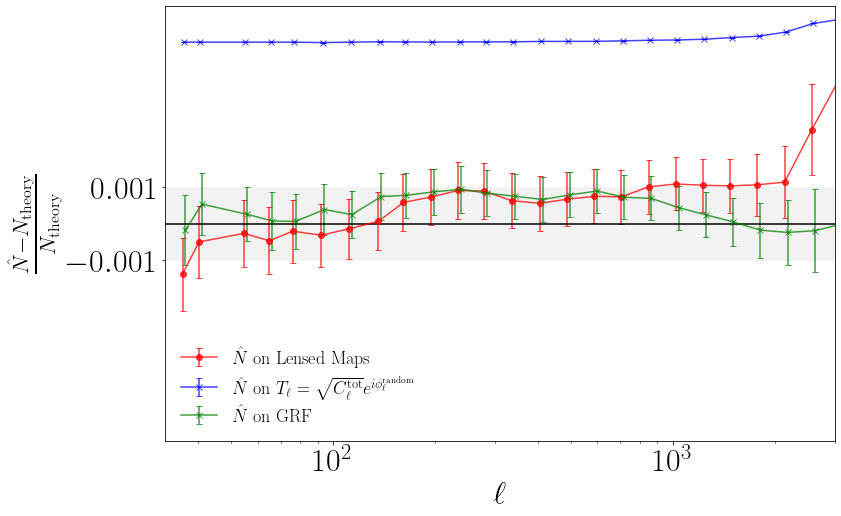

In [23]:
offset=0.01


fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['-1-1']))
lCen1, Cl1, sCl1 = LBinned, NtheoryBinned, np.zeros_like(sCl0)




# print((Cl0-Cl1)/Cl0)
assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (ra*Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='o-', capsize=3, capthick=1, c='red', label=r'$\hat N$ on Lensed Maps')#, label=labels[key], c=colors[key])

tmp = [l*np.exp(offset*1)-l for l in lCen0]


lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['-3-3']))
ax.errorbar(lCen0+tmp, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='blue', label=r'$\hat N$ on $T_\ell = \sqrt{C_\ell^{\rm tot}} e^{i\phi_\ell^{\rm random}}$')#, label=labels[key], c=colors[key])


tmp = [l*np.exp(offset*2)-l for l in lCen0]

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['-2-2']))
ax.errorbar(lCen0+tmp, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='Green', label=r'$\hat N$ on GRF')#, label=labels[key], c=colors[key])

# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF havled']))
# ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='lightgreen', label=r'$\hat N$ on GRF [Halved Stats]')#, label=labels[key], c=colors[key])


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.95')#, label=r'$<1\%$ Error')

# ax.set_yscale('symlog', linthresh=.5e-2) 

ax.axhline(0, c='k')

ax.set_ylim(-.06e-1, .06e-1)
ax.set_xlim(32, 3000)
ax.set_yticks([-0.001,0.001,])#- 0.002,0.001, 0.002])
ax.legend(frameon=False)
# ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])


In [ ]:
# offset=0.03


# fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 20

# ell = baseMap.l.flatten()

# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['QEQE']))
# lCen1, Cl1, sCl1 = LBinned, NtheoryBinned, np.zeros_like(sCl0)


# # print((Cl0-Cl1)/Cl0)
# assert(all(lCen0 == lCen1))
# ax.errorbar(lCen0, Cl0, yerr=sCl0, alpha=0.75, 
#             fmt='o-', capsize=3, capthick=1, c='red', label=r'QEQE')#, label=labels[key], c=colors[key])



# lCen1, Cl1, sCl1 = LBinned, fKKBinned, np.zeros_like(fKK)
# ax.errorbar(lCen1, Cl1, yerr=sCl1, alpha=0.75, 
#             fmt='o-', capsize=3, capthick=1, c='black', label=r'KK')#, label=labels[key], c=colors[key])

# # tmp = [l*np.exp(offset*1)-l for l in lCen0]


# # lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF random']))
# # ax.errorbar(lCen0+tmp, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
# #             fmt='x-', capsize=3, capthick=1, c='blue', label=r'$\hat N$ on $T_\ell = \sqrt{C_\ell^{\rm tot}} e^{i\phi_\ell^{\rm random}}$')#, label=labels[key], c=colors[key])


# # tmp = [l*np.exp(offset*2)-l for l in lCen0]

# # lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
# # ax.errorbar(lCen0+tmp, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
# #             fmt='x-', capsize=3, capthick=1, c='Green', label=r'$\hat N$ on GRF')#, label=labels[key], c=colors[key])

# # lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF havled']))
# # ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
# #             fmt='x-', capsize=3, capthick=1, c='lightgreen', label=r'$\hat N$ on GRF [Halved Stats]')#, label=labels[key], c=colors[key])


# ax.legend(frameon=False)
# ax.set_xscale('log')
# ax.set_xlabel(r'$\ell$')
# ax.set_ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
# ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

# # ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
# # ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
# ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.75')#, label=r'$<1\%$ Error')

# # ax.set_yscale('symlog', linthresh=.5e-2) 

# ax.axhline(0, c='k')

# ax.set_ylim(-.98e-2, .98e-2)
# ax.set_xlim(42, 3000)
# ax.legend(frameon=False)
# # ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])


In [ ]:
tmp_norm = baseMap.computeQuadEstPhiNormalizationFFT(fTgradT, cmb.fCtotal)

tmp_norm = np.real(tmp_norm)
# remove the nans
tmp_norm = np.nan_to_num(tmp_norm)
# make sure every value is positive
tmp_norm = np.abs(tmp_norm)

In [ ]:
lnorm, normps, _ = baseMap.powerSpectrum(tmp_norm)

In [ ]:
fnorm = interp1d(lnorm, normps, kind='linear', bounds_error=False, fill_value=0.)

In [ ]:
fnorm = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax)

In [ ]:
plt.plot(L, np.array(list(map(fnorm, L))), label='norm')
plt.plot(L, list(map(Ntheory,L)),label='ntheory')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([7e-8,1e-6])

In [ ]:
plt.plot(L, list(map(flensedTT, L)))
plt.plot(L, list(map(ftot,L)))
plt.plot(L, list(map(fTgradT,L)))

plt.xscale('log')
plt.yscale('log')

We showed in the paper tthat Nhat(GRF) should be biased by
$${\rm correction} = 2 N_{\rm theory}^2 F_{L/2, L/2}^2 (C_{L/2}^{\rm tot})^2$$

$$F_{L/2, L/2} = \frac{f_{L/2, L/2}}{2 (C_{L/2}^{\rm tot})^2}$$
$$f_{L/2, L/2} = 2/(L)^2 \times (L)\cdot L C_{L/2}^{T\nabla T}=2 C_{L/2}^{T\nabla T}$$

$$F_{L/2, L/2} = \frac{ C_{L/2}^{T\nabla T}}{ (C_{L/2}^{\rm tot})^2}$$

$${\rm correction} = 2 N_{\rm theory}^2 \times  \frac{(C_{L/2}^{T\nabla T})^2}{ (C_{L/2}^{\rm tot})^2}  $$
EDIT: IGNORE AND SEE PAPER

In [ ]:
correction = lambda L: 1/2*fnorm(L)**2*fTgradT(L/2)**2 / ftot(L/2)**2  * 1/(baseMap.sizeX * baseMap.sizeY)

In [ ]:
offset=0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(16,10))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['Nhat']))
lCen1, Cl1, sCl1 = LBinned, NtheoryBinned, np.zeros_like(sCl0)



# print((Cl0-Cl1)/Cl0)
assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='o-', capsize=3, capthick=1, c='red', label=r'$\hat N$ on "Real" Data')#, label=labels[key], c=colors[key])



lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF random']))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='blue', label=r'$\hat N$ on $T_\ell = \sqrt{C_\ell^{\rm tot}} e^{i\phi_\ell^{\rm random}}$')#, label=labels[key], c=colors[key])

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='Green', label=r'$\hat N$ on GRF')#, label=labels[key], c=colors[key])

# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF havled']))
# ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='lightgreen', label=r'$\hat N$ on GRF [Halved Stats]')#, label=labels[key], c=colors[key])

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

# ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
# ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')


corr = np.array(list(map(correction, lCen0)))
# print((corr)/Cl1)
# plt.scatter(lCen0, (16)*(corr)/Cl1, label=r'correction $\times$ 16', c='purple', s=10)
plt.scatter(lCen0, (corr)/Cl1, label='correction', c='k', s=10)
# print((corr)/Cl1)
# plt.scatter(lCen0, (2*np.pi)**2/2*(corr)/Cl1, label=r'correction $\times (2\pi)^2/2$', c='pink', s=10)


# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
# ax.errorbar(lCen0, (Cl0-16*corr-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='purple', label=r'$\hat N$ on GRF $-16\times$Correction')#, label=labels[key], c=colors[key])
# ax.errorbar(lCen0, (Cl0-(2*np.pi)**2/2*corr-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='pink', label=r'$\hat N$ on GRF $-(2\pi)^2/2\times$Correction')#, label=labels[key], c=colors[key])

# ax.set_yscale('symlog', linthresh=.5e-2) 

ax.axhline(0, c='k')

ax.set_ylim(-.98e-2, .98e-2)
ax.legend(frameon=False)
# ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])
